Importing necessary libraries

In [ ]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import os

%matplotlib inline
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

Loading the Dataset

In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/color")
train='/content/drive/MyDrive/color'

In [ ]:
dataset_path_train = os.listdir(data_dir)
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['Apple___Cedar_apple_rust', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Corn_(maize)___Common_rust_', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Apple___healthy', 'Cherry_(including_sour)___healthy', 'Peach___healthy', 'Corn_(maize)___healthy', 'Pepper,_bell___healthy', 'Pepper,_bell___Bacterial_spot', 'Potato___healthy', 'Potato___Late_blight', 'Strawberry___healthy', 'Tomato___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot']
Types of classes labels found:  18


In [ ]:
image_count_train = len(list(data_dir.glob('*/*.JPG')))
print("The number of Train data:",image_count_train)

The number of Train data: 0


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

Split the data

In [ ]:
train_ds = image_dataset_from_directory(data_dir, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 4825 files belonging to 18 classes.
Using 3860 files for training.


In [ ]:
val_ds = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 4825 files belonging to 18 classes.
Using 965 files for validation.


In [ ]:
test = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=None)

Found 4825 files belonging to 18 classes.


In [ ]:
class_names = train_ds.class_names
print(len(class_names))
print( class_names)

18
['Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___healthy']


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)


(32, 224, 224, 3)
(32,)


Model Design

In [ ]:
num_classes = 18

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))
# Compile the model 

## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 112, 112, 32)      0         
                                                        

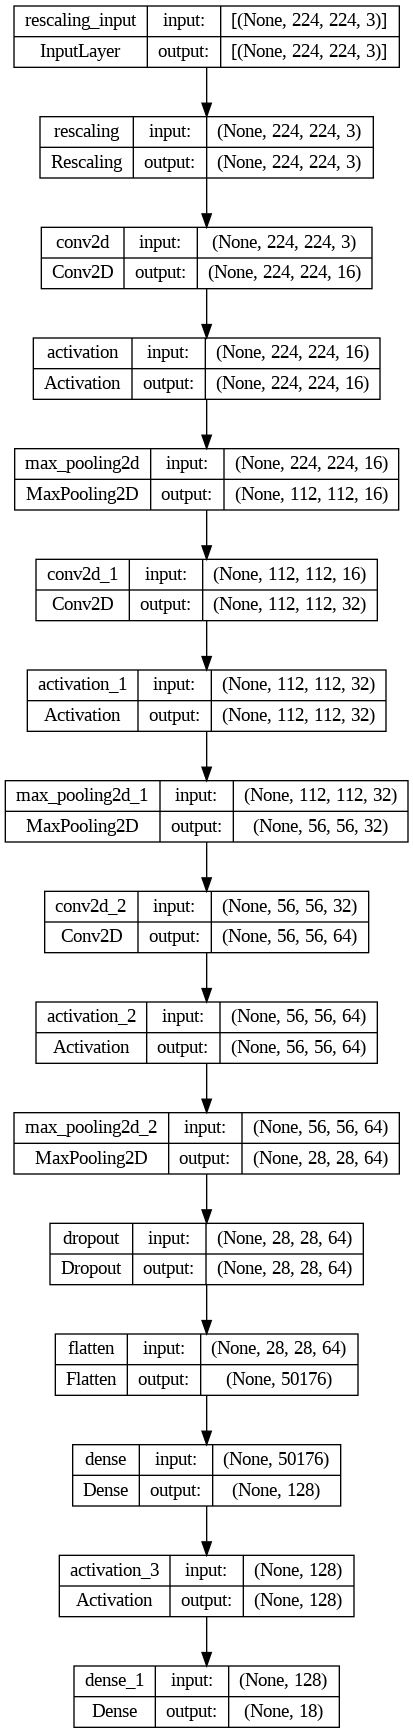

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)


In [ ]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
121/121 [==============================] - 559s 5s/step - loss: 1.8895 - accuracy: 0.4238 - val_loss: 0.9392 - val_accuracy: 0.7130
Epoch 2/10
121/121 [==============================] - 270s 2s/step - loss: 0.7095 - accuracy: 0.7756 - val_loss: 0.5864 - val_accuracy: 0.8093
Epoch 3/10
121/121 [==============================] - 276s 2s/step - loss: 0.4103 - accuracy: 0.8611 - val_loss: 0.5245 - val_accuracy: 0.8363
Epoch 4/10
121/121 [==============================] - 268s 2s/step - loss: 0.2450 - accuracy: 0.9215 - val_loss: 0.4780 - val_accuracy: 0.8674
Epoch 5/10
121/121 [==============================] - 276s 2s/step - loss: 0.1512 - accuracy: 0.9541 - val_loss: 0.4685 - val_accuracy: 0.8653
Epoch 6/10
121/121 [==============================] - 268s 2s/step - loss: 0.1246 - accuracy: 0.9635 - val_loss: 0.5541 - val_accuracy: 0.8415
Epoch 7/10
121/121 [==============================] - 267s 2s/step - loss: 0.1260 - accuracy: 0.9562 - val_loss: 0.4733 - val_accuracy: 0.8622

Model design with regularization

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
num_classes = 18

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
seq = Sequential()
seq.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)))
seq.add(Conv2D(16, 3, padding='same'))
seq.add(Activation('relu'))
seq.add(MaxPooling2D())

seq.add(Conv2D(32, 3, padding='same'))
seq.add(Activation('relu'))
seq.add(MaxPooling2D())
seq.add(Dropout(0.25))
seq.add(Conv2D(64, 3, padding='same'))
seq.add(Activation('relu'))
seq.add(MaxPooling2D())
seq.add(Dropout(0.15))

seq.add(Flatten())
seq.add(Dense(128,kernel_regularizer='l1'))
seq.add(Activation('relu'))
seq.add(Dense(num_classes))
# Compile the model 

## Your code goes here
seq.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
seq.summary()

Model training - with regularization

In [ ]:
epochs = 10

model2 = seq.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
performance = seq.evaluate(val_ds)
performance

Evaluation

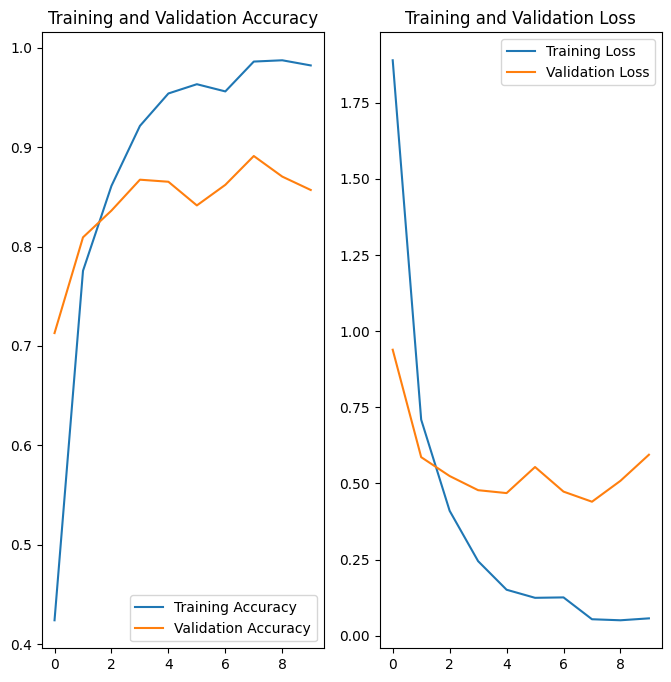

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
performance = model.evaluate(val_ds)
performance

31/31 [==============================] - 35s 1s/step - loss: 0.5944 - accuracy: 0.8570


[0.5944082736968994, 0.8569948077201843]

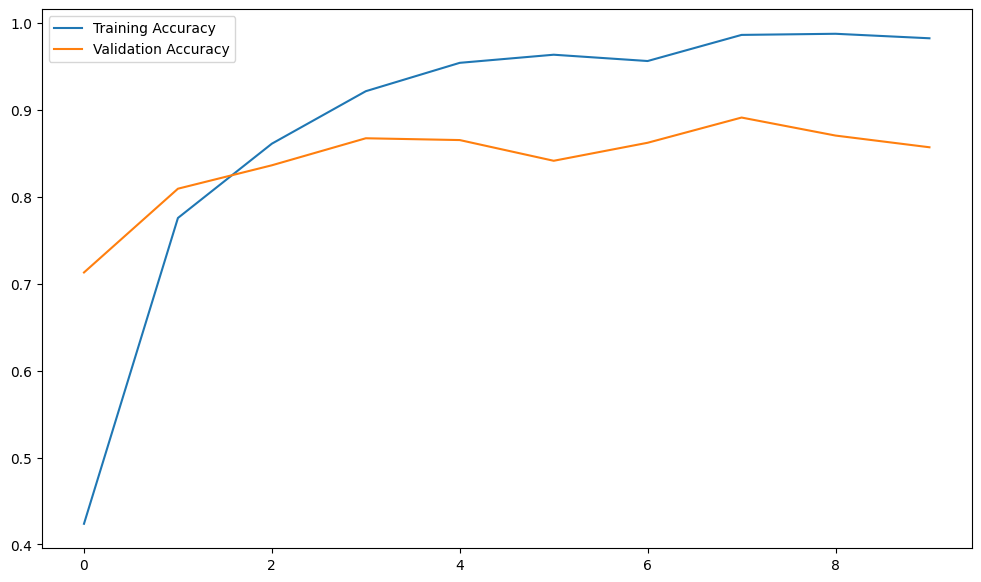

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
no_of_epochs = history.params['epochs']
len(history.history['accuracy']) == no_of_epochs
plt.figure(figsize=(12, 7))

plt.plot(range(no_of_epochs), acc, label='Training Accuracy')
plt.plot(range(no_of_epochs), val_acc, label='Validation Accuracy')

plt.legend()
plt.show()

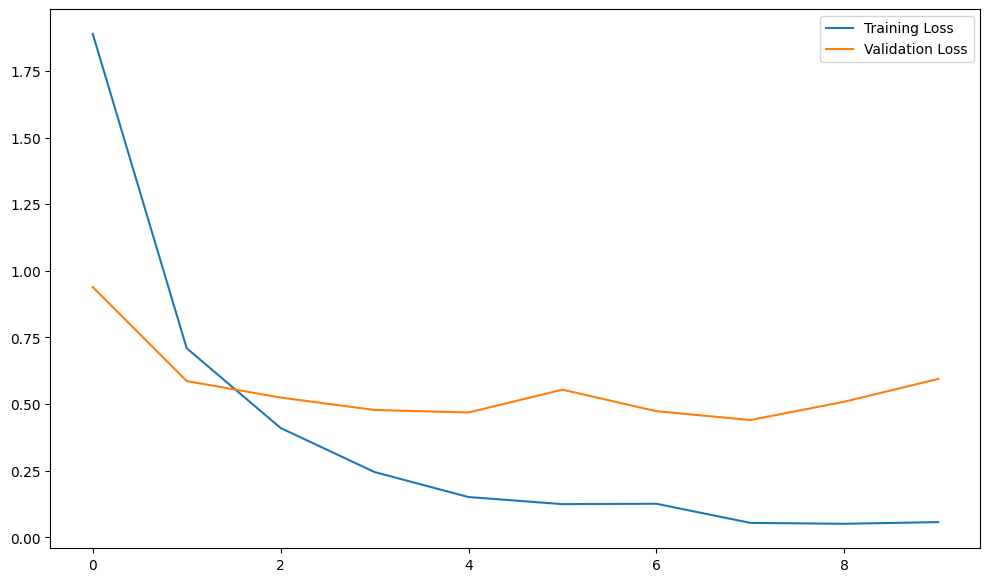

In [ ]:
plt.figure(figsize=(12, 7))

plt.plot(range(no_of_epochs), loss, label='Training Loss')
plt.plot(range(no_of_epochs), val_loss, label='Validation Loss')

plt.legend()
plt.show()

Prediction

actual label: Strawberry___Leaf_scorch
1/1 [==============================] - 1s 732ms/step
predicted label: Strawberry___Leaf_scorch


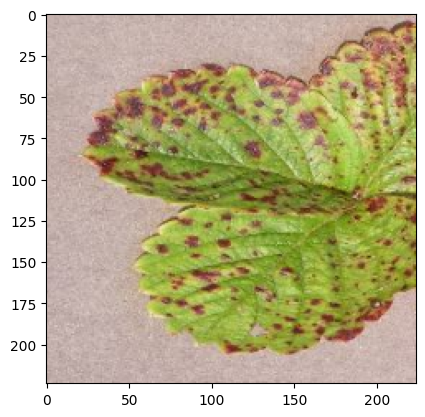

In [ ]:
labels = train_ds.class_names
labels
for images_batch, labels_batch in test.take(1):
    
    image = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    
    plt.imshow(image)
    print("actual label:", labels[label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", labels[np.argmax(batch_prediction[0])])

In [ ]:
from tensorflow import expand_dims, newaxis

def predict(model, img):
    
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round( (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step


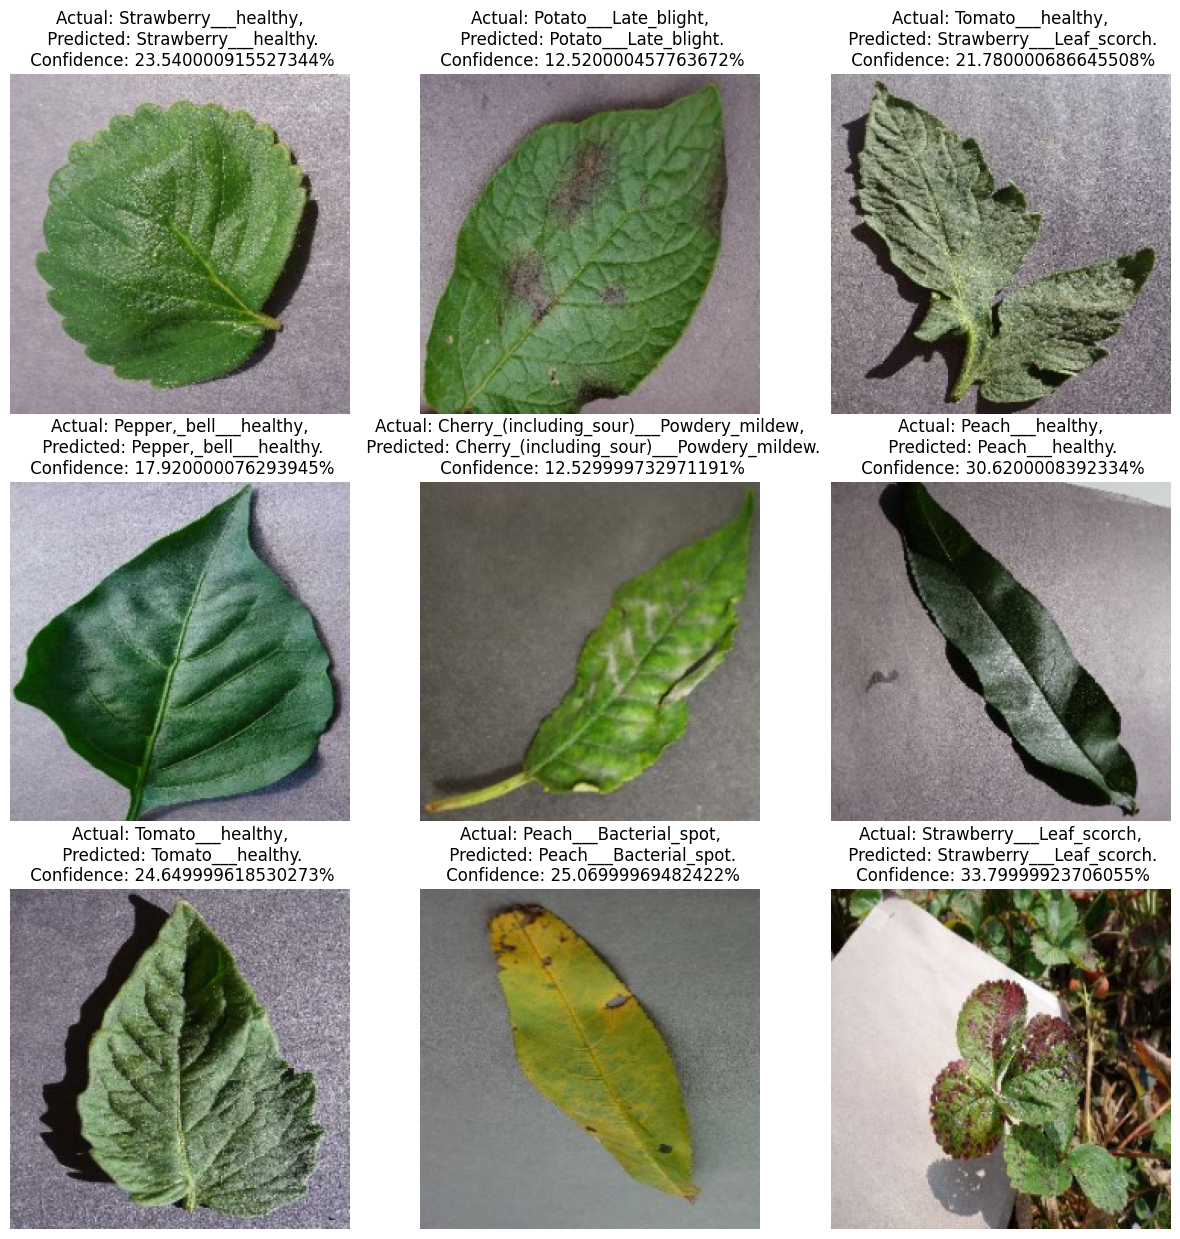

In [ ]:
plt.figure(figsize=(15, 15))

for images, lbs in val_ds.take(1):
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save("plantModel.h5")